# Configure Watson OpenScale 

## Introduction

Watson OpenScale tracks and measures outcomes from your models. This notebook walks through configuring OpenScale to the model we previously deployed in the `2-modeling` notebook. After configuration we will set up monitors to ensure the model remains fair, explainable and compliant while running. We will also set up a monitor to detect and help correct drift in accuracy while the model is in production.  

The notebook is organized in the following fashion:

0. Setup  
1. Create Model Subscription
2. Payload Logging
3. Setup & Use Monitors
4. Log Historical Metrics

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2020. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.<br>**

<br>

# 0.  Setup


## 0.1 Package Installation

The pre-installed version of `scikit-learn` is "0.22.1" The version of scikit-learn that is needed for compatibility across all components of this accelerator is "0.20.2"
The line of code bloakc will change version of `scikit-learn` and install `ibm_wos_utils`, which is package used to configure the drift monitor later in the notebook.

In [24]:
!pip install ibm_wos_utils --no-cache | tail -n 1
!pip install scikit-learn==0.20 --no-cache | tail -n 1

<br>

## 0.2 Load Dependencies

In [25]:
from ibm_ai_openscale import APIClient4ICP
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *
from watson_machine_learning_client import WatsonMachineLearningAPIClient

from sqlalchemy import create_engine
from sqlalchemy.types import VARCHAR, CHAR, DECIMAL, INTEGER, DATE, BOOLEAN

import os

import pandas as pd
from IPython.display import Image
from tqdm import tqdm_notebook

import datetime

%matplotlib inline

# READING AND WRITING PROJECT ASSETS
import project_lib
project = project_lib.Project()

<br>

## 0.3 Manage Access & User Inputs

### 0.3.0 Confirm OpenScale User Access

It's common practice for the system admin to restrict access to the OpenScale service to a few users. If you are unsure if you have access to the service. check with your admin before running this notebook. Keep in mind if you do not have proper access, the client may allow you to connect and get part of the way through before breaking when configuring certain monitors. Once you have the correct credential information you need to add the user to the deployment space. 

From the hamburger menu on the top left corner of the screen under Analyze select Analytics Deployments. From that screen you should see the `loan_default_deploy_space`, click on the space and navigate to the Access Control tab. From here you can see a list of all the users with access. If the username with access to OpenScale is not there, add them by clicking add collaborators, entering in the username and changing the role to admin.

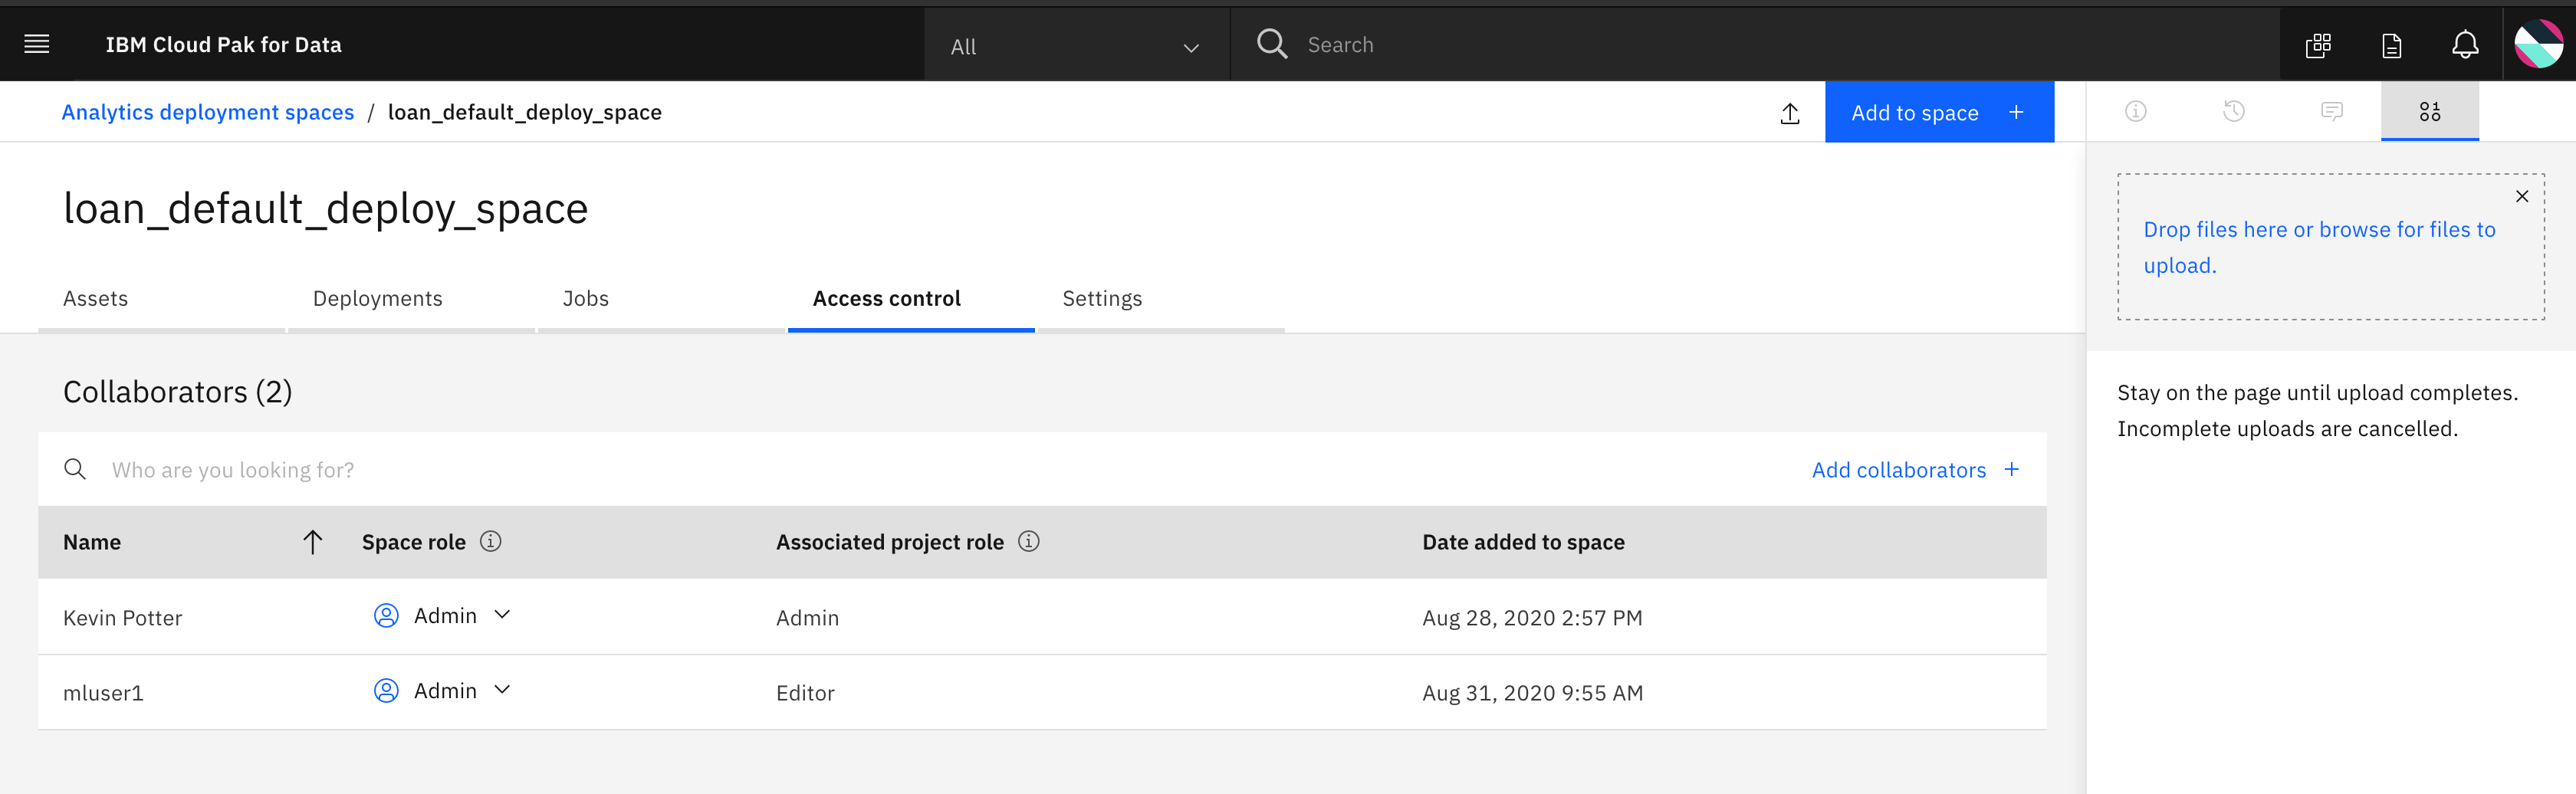

In [26]:
Image(project.get_file('loan_default_UI_4.png').read(), width=1000, height=700)

<br>
<br>

### 0.3.1 Enter Credentials & Define Thresholds

Enter the credentials and cluster URL. The cluster URL is the same one that was provided to you by your system administrator when logging on to the cluster and end in .com. The `SPACE_NAME`, `MODEL_NAME`, and `DEPLOYMENT_NAME` are the names of the assets previously created in the `modeling-2` notebook. The thresholds correspond to monitors we will configure throughout the notebook. 

- WML_THRESHOLD - is the threshold defined in the `modeling-2` notebook used in scoring the model
- QUALITY_THRESHOLD - Sends an alert in the OpenScale UI when the quality of predictions falls below 50%
- FAIRNESS_THRESHOLD - Sends an alert when the bias falls below 95%
- DRIFT_THRESHOLD - Sends an alert when the predictions see a drop in performance of greater that 10%

In [27]:
# These credentials are specific to the provisioned OpenScale service
CLUSTER_URL = '<ENTER URL>'
WOS_USERNAME = '<ENTER USERNAME>'
WOS_PASSWORD = '<ENTER PASSWORD>'

# These variables were named in the 2-modeling notebook
MODEL_NAME = 'loan_default_model'
DEPLOYMENT_NAME = 'loan_default_deployment'

# Define Thresholds
WML_THRESHOLD = 0.21  
QUALITY_THRESHOLD = .5 
FAIRNESS_THRESHOLD = .95 
DRIFT_THRESHOLD = 0.1 

<br>

## 0.4 Create OpenScale and Watson Machine Learning Client Connections

In this step we create the Watson Machine Learning and OpenScale clients, get the `deployment_space_uid`, and set the default space.

In [28]:
token = os.environ['USER_ACCESS_TOKEN']
url = os.environ['RUNTIME_ENV_APSX_URL']

WML_CREDNETIAL = {
   "token": token,
   "instance_id" : "openshift",
   "url": url,
   "version": "2.5.0"
}

wml_client = WatsonMachineLearningAPIClient(WML_CREDNETIAL)


WOS_CREDENTIAL = {
    "url":CLUSTER_URL,
    "username": WOS_USERNAME,
    "password": WOS_PASSWORD
}

ai_client = APIClient4ICP(WOS_CREDENTIAL)

# set space ID
deployment_space_uid = os.environ['SPACE_ID']
wml_client.set.default_space(deployment_space_uid)

'SUCCESS'

<br/> 

Collect the UID for deployment and model to be use later in the notebook 

In [29]:
model_deployment_uid = [x['metadata']['guid'] for x in wml_client.deployments.get_details()['resources'] if x['entity']['name'] == DEPLOYMENT_NAME][0]
model_uid = [x['metadata']['guid'] for x in wml_client.repository.get_model_details()['resources'] if x['entity']['name'] == MODEL_NAME][0]

<br>  

# 1.0 Create Model Subscription

A subscription is the connection between OpenScale and your deployed model. It's important to make sure all the parameters you are inputting to your configuration are complete and accurate. Creating a subscription that is not configured correctly can lead to difficulty in when using the various monitors later on.

## 1.1 Create OpenScale Client & Binding

Before you can create the subscription to the `loan_default_model` you must first create the binding between OpenScale and the `loan_default_deploy_space`. Creating the binding will give OpenScale access to all the deployed assets within that space.

In [30]:
BINDING_NAME = 'Loan-Defualt-Binding'
binding_uid = [x['metadata']['guid'] for x in ai_client.data_mart.bindings.get_details()['service_bindings'] if x['entity']['name'] == BINDING_NAME]
if not binding_uid:
    print("Creating New Binding")
    binding_uid = ai_client.data_mart.bindings.add(BINDING_NAME, 
                                               WatsonMachineLearningInstance4ICP({
                                                   "url": CLUSTER_URL,
                                                   "username": WOS_USERNAME,
                                                   "password": WOS_PASSWORD,
                                                   "instance_id": deployment_space_uid    
                                               }))
else:
    print('Binding already exists with id:', binding_uid[0])   

Creating New Binding


<br/> 

## 1.2 Verify Successful Binding 

To configure the set up the monitiors and subsciption we recreate the client without the `instance_guid` and `data_mart_id`. This information is only needed to create the binding. After setting up the the OpenScale client we use the `model_deployment_uid` to see if the bining we just created is there. If the table is empty, there was an issue creating the binding. 

In [31]:
ai_client.data_mart.bindings.list_asset_deployments(deployment_uid=model_deployment_uid)

Status code: 500, body: {"trace":"java.lang.RuntimeException: AIQGS0023E : BindingOrInstanceId = 4377a489-af4d-4675-9185-7f1d46c9a3eb, ServiceType = watson_machine_learning, SubscriptionId = null : GetDeployments failed java.lang.Exception: AIQGS0045E : Could not get ICPToken using password..\n\tat com.ibm.aios.mlgateway.discovery.impl.WMLDeployments.getDeploymentCollectionBySpaceId(WMLDeployments.java:390)\n\tat com.ibm.aios.mlgateway.discovery.impl.WMLDeployments.getDeploymentCollection(WMLDeployments.java:243)\n\tat com.ibm.aios.mlgateway.discovery.impl.WMLDeployments.getDeployments(WMLDeployments.java:210)\n\tat com.ibm.aios.mlgateway.api.server.impl.DeploymentCollectionFactory.getDeploymentCollection(DeploymentCollectionFactory.java:92)\n\tat com.ibm.aios.mlgateway.api.server.impl.V1ApiServiceImpl.getDeploymentsByBindingId(V1ApiServiceImpl.java:218)\n\tat com.ibm.aios.mlgateway.api.server.V1Api.getDeploymentsByBindingId(V1Api.java:135)\n\tat sun.reflect.GeneratedMethodAccessor149.

<br>

## 1.3 Create OpenScale Subscription

We only want OpenScale to monitor the features our model is actually making predictions on. In our case the deployment pipeline takes in an extended set of features and drops columns before within the pipeline (see modeling notebook for further details). Below is the complete list of features as well as a subset of categorical features our model is using for prediction.

To create the subscription OpenScale needs the `model_uid`, `problem_type`, `label_column`, `feature_columns`, and `categorical_columns`. We gather the `model_uid` from our Watson Machine Learning client and pass in the rest of the information as parameters. The `loan_default_model` is a binary classification that makes predictions for `default_12mth`.

In [32]:
feature_list = ['loan_payment_amount',
                'loan_duration',
                'loan_remaining_principal',
                'loan_remaining_principal_pct',
                'age_card',
                'balance_mean_current_month',
                'balance_std_current_month',
                'balance_std_current_quarter',
                'balance_std_current_year',
                'balance_kurt_current_year',
                'balance_pct_change_qoq_consecutive',
                'balance_pct_change_qoq_seasonal',
                'balance_ratio_std_to_mean_current_year',
                'tx_credit_avg_amount',
                'tx_monthly_avg_credit_count',
                'tx_monthly_avg_credit_pct',
                'tx_monthly_avg_cash_withdrawals_pct',
                'tx_monthly_avg_credit_in_cash_pct',
                'tx_monthly_avg_interest_credited_pct',
                'tx_monthly_avg_overdraft_fees_pct',
                'tx_monthly_avg_weekend_transactions_pct',
                'loan_missing_payment',
                'second_account_holder',
                'sex_primary_is_female',
                'sex_secondary_is_female',
                'loan_purpose', 
                'branch_id', 
                'debit_card_type', 
                'branch_city'
               ]

categorical_features = ['loan_purpose',
                        'branch_id',
                        'debit_card_type',
                        'branch_city',
                        'loan_missing_payment', 
                        'second_account_holder',
                        'sex_primary_is_female',
                        'sex_secondary_is_female']


subscription_uid = [x['metadata']['guid'] for x in ai_client.data_mart.subscriptions.get_details()['subscriptions'] if x['entity']['asset']['name'] == MODEL_NAME]
if subscription_uid:
    print('Deleting existing subscription for', MODEL_NAME)
    ai_client.data_mart.subscriptions.delete(subscription_uid[0])

print('Creating new subscription...')
subscription = ai_client.data_mart.subscriptions.add(WatsonMachineLearningAsset(
    model_uid,
    problem_type=ProblemType.BINARY_CLASSIFICATION,
    input_data_type=InputDataType.STRUCTURED,
    label_column='default_12mth',
    prediction_column='prediction',
    probability_column='probability',
    feature_columns=feature_list,
    categorical_columns=categorical_features
))

print('Subscription created with id:', subscription.uid)

Creating new subscription...
Subscription created with id: 6bd4ee3c-67fd-4ccc-9743-5265182d5ed8


<br>
<br>

# 2.0 Payload Logging

The way that OpenScale monitors activity is through payload logging. Once you score the model, the details of the record are sent to OpenScale, saved, and then can be tracked by the various monitors. It is important to note that when OpenScale is on a separate cluster to automatically log payloads you will need to send the service `binding_id` and `subscription_id` in the payload. 

To complete the setup of your OpenScale connection you must first log at least one payload manually and the OpenScale UI will provide you with some code to get started. The below cells are a walkthrough of how to send a request and log it to OpenScale manually


## 2.1 Load Training & Validation Data

There are predefined training and validation sets called `df_training.csv` and `df_validation.csv` in the `/project_data/data_asset/` folder.
Alternatively, these files can be accessed by clicking on the 0100 tab in the top right corner, finding the desired files, and clicking Insert to code, then Insert pandas DataFrame.

In [33]:
df_training = pd.read_csv(project.get_file('df_training.csv'))
X_train = df_training.drop(['default_12mth', 'date_of_last_payment','default', 'date_of_default'], axis=1)

df_validation = pd.read_csv(project.get_file('df_validation.csv'))
X_val = df_validation.drop(['default_12mth', 'date_of_last_payment', 'default', 'date_of_default'], axis=1)

<br>

## 2.2 Score Model and log the Payloads with OpenScale

We score the model and send the results to OpenScale in bathes to ensure logging is processed effectively and return the first 5 rows to validate the payloads were logged successfully. 

In [34]:
for prediction_date, group in X_val.groupby('prediction_date').groups.items():
    # SCORE AND LOG PAYLOAD
    payload_scoring = {'input_data': [{'fields': X_val.columns,
                                       'values': X_val.loc[group, :]}
                                     ]}
    response = wml_client.deployments.score(model_deployment_uid, payload_scoring)
    
    for i, x in enumerate(response['predictions'][0]['values']):
        proba_default = x[1][1]
        response['predictions'][0]['values'][i][0] = proba_default >= WML_THRESHOLD

    records = [PayloadRecord(request=payload_scoring, response=response)]
    subscription.payload_logging.store(records=records)

# View first 5 rosw
time.sleep(10)
subscription.payload_logging.show_table(limit=5)

<br>
<br>

# 3.0 Set & Use Monitors

Now that the subscription has been made and payloads have been logged we can choose what monitors to set up. For our loan default model, we want to monitor the following

- Quality 
- Fairness
- Explainability
- Drift
 

## 3.1 Quality Monitoring

For our model we will set the threshold quality to 50% where OpenScale will show an alert on the dashboard if the model accuracy measurement (area under the curve, in the case of a binary classifier) falls below this threshold.

The second parameter supplied, `min_records`, specifies the minimum number of feedback records OpenScale needs before it calculates a new measurement. The quality monitor runs hourly, but the accuracy reading in the dashboard will not change until an additional 50 feedback records have been added, via the user interface, the Python client, or the supplied feedback endpoint.

### 3.1.0 Enable Monitor

In [35]:
subscription.quality_monitoring.enable(threshold=QUALITY_THRESHOLD, min_records=50)

<br> 

### 3.1.1 Feedback Logging

Quality needs a baseline dataset that includes the outcomes to be able to detect the change. The code below downloads and stores enough feedback data to meet the minimum threshold so that OpenScale can calculate a new accuracy measurement. It then kicks off the accuracy monitor. The monitors run hourly, or can be initiated via the Python API, the REST API, or the graphical user interface.

Feedback logging needs to be stored in the order the service was set up. The first line of code creates a list containing the features and order OpenScale expects then store it in the table.

In [36]:
wos_feature_order = [feature['name'] for feature in subscription.get_details()['entity']['asset_properties']['training_data_schema']['fields']]
feedback_data = df_validation[wos_feature_order]

subscription.feedback_logging.store(feedback_data.values.tolist(), data_header=True)

### 3.1.2 Run Quality Monitoring

In [37]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run ce872edb-fdc8-4747-b48c-5d49085dbc48 




initializing
running
completed

---------------------------
 Successfully finished run 
---------------------------




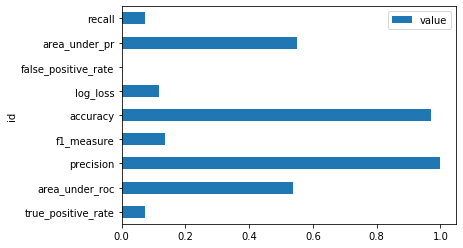

In [38]:
time.sleep(30)
quality_pd = subscription.quality_monitoring.get_table_content(format='pandas', limit=1000)
quality_pd[quality_pd['ts'] == quality_pd['ts'].max()].plot.barh(x='id', y='value');

## 3.2 Fairness Monitoring


The code below configures fairness monitoring for our model. We will configure the monitor on to alert us for cetegorical features `sex_primary_is_female` and `sex_secondary_is_female`.

In each case, we must specify:

- Which model feature to monitor
- One or more majority groups, which are values of that feature that we expect to receive a higher percentage of favorable outcomes
- One or more minority groups, which are values of that feature that we expect to receive a higher percentage of unfavorable outcomes
- The threshold at which we would like OpenScale to display an alert if the fairness measurement falls below (in this case, 95%)

Additionally, we must specify which outcomes from the model are favourable outcomes, and which are unfavourable. We must also provide the number of records OpenScale will use to calculate the fairness score. OpenScale's fairness monitor will run hourly, but will not calculate a new fairness rating until at least 5 records have been added. Finally, to calculate fairness, OpenScale must perform some calculations on the training data, so we provide `df_training`.

### 3.2.0 Enable Monitor

In [39]:
subscription.fairness_monitoring.enable(
    features=[
        Feature("sex_primary_is_female", majority=['N'], minority=['Y'], threshold=FAIRNESS_THRESHOLD),
        Feature("sex_secondary_is_female", majority=['N'], minority=['Y'], threshold=FAIRNESS_THRESHOLD)
    ],
    favourable_classes= [0],
    unfavourable_classes= [1],
    min_records=50,
    training_data=df_training.copy(deep=True)
)

### 3.2.1 Run Fairness Monitor

In [40]:
run_details = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=072d10d4-b5c9-4ebc-b0fe-ddb5d5253b00 




RUNNING.
FINISHED

---------------------------
 Successfully finished run 
---------------------------




<br>

Fairness takes time to log so we wait for the table to populate before viewing the results

In [41]:
time.sleep(180)
subscription.fairness_monitoring.show_table(limit=5)

<br>

## 3.3 Enable Explainability Monitoring

Explainability provides us with detailed information on a per observation basis. This will allow the Loan Officer to look at the features that are contributing to a particular prediction and take appropriate action.

Similar to the payload data, we will organize and store this information in a DB2 Table to be used by Cognos.


### 3.3.0 Enable Explainability Monitor

In [42]:
subscription.explainability.enable(training_data=df_training)

<br>

### 3.3.1 Run Explainability Monitor

This step extracts the `scoring_id` from the `payload_logging` table and runs the explainability monitor for that record. The output is a dictionary that contains all of the explanation weights and corresponding features.

In [43]:
payloads = subscription.payload_logging.get_table_content(limit=1)
explanation = subscription.explainability.run(payloads['scoring_id'][0], cem=False, background_mode=False)




 Looking for explanation for f07ed7e9-9fd7-4c26-afd6-84391d422ce2-155 




in_progress.
finished

---------------------------
 Successfully finished run 
---------------------------




<br> 

### 3.3.2 View Explaination Results

This cell extracts the weights and features from out output above and outputs a bar chart to easily visualize the results.

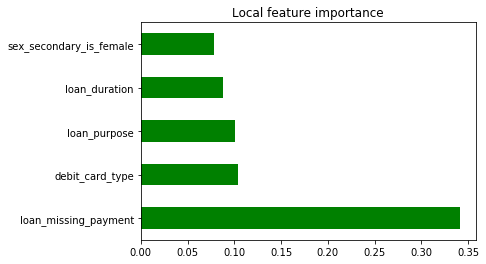

In [44]:
weights = pd.Series({x['feature_name']: x['weight'] for x in explanation['entity']['predictions'][0]['explanation_features']})
weights = weights.reindex(feature_list, axis=1)

weights.sort_values(ascending=False).head(5).plot(kind='barh', color='g', title='Local feature importance');

<br> 

## 3.4 Enable Drift Monitoring

Drift is the degradation of predictive performance over time because of hidden context. As your data changes over time, the ability of your model to make accurate predictions may deteriorate. 

The below code are the steps outline how to enable drift using a pandas dataframe as the training data reference. To do so we download the model from WML and pass it into our score function to be used in training. The `drift_trainer` package then performs all of the scoring, optimization, and learning in the notebook then saves the output as `drift_detection_model.tar.gz`. We will then pass this training file when enabling the drift service and run the monitor.

### 3.4.0 Load in WML Model

In [45]:
model = wml_client.repository.load(model_uid)

<br> 

### 3.4.1 Run Drift Trainer

The `drift_trainer` will perform similar tests the actual monitor runs on your model locally, then saves the output as a `.tsr` file.

In [46]:
def score(data):
    """
    From the generate_drift_detection_model docs:
    A function that accepts a dataframe with features as columns and returns a tuple of numpy array
    of probabilities array of shape `(n_samples,n_classes)` and numpy array of prediction vector of shape `(n_samples,)`
    """
    return model.predict_proba(data), model.predict(data)

In [47]:
#Generate drift detection model
from ibm_wos_utils.drift.drift_trainer import DriftTrainer

drift_detection_input = {
    "feature_columns": feature_list,
    "categorical_columns": categorical_features,
    "label_column": 'default_12mth',
    "problem_type": 'binary'
}
    
drift_trainer = DriftTrainer(df_training, drift_detection_input)

# Note: Two column constraints are not computed beyond two_column_learner_limit(default set to 200)
# User can adjust the value depending on the requirement
drift_trainer.generate_drift_detection_model(score, batch_size=df_training.shape[0])
drift_trainer.learn_constraints(two_column_learner_limit=200)
drift_trainer.create_archive()

Learning two feature constraints...: 100%|██████████| 405/405 [00:08<00:00, 49.03constraints/s] 


### 3.4.2 Enable Drift Monitor

We designate a threshold of 10% with `min_records=50` to have an alert sent to the dashboard when these thresholds are met. Then we take the output file of the `drift_trainer` and pass it into the enable method.

In [48]:
subscription.drift_monitoring.enable(min_records=50, threshold=DRIFT_THRESHOLD, model_path='./drift_detection_model.tar.gz')

{'config_status': {'state': 'finished'},
 'data_drift_enabled': True,
 'drift_threshold': 0.1,
 'is_schedule_enabled': False,
 'min_samples': 50,
 'model_drift_enabled': True,
 'schedule_repeat_interval': 3,
 'schedule_repeat_type': 'hour'}

### 3.4.4 Run Monitor

Drift will automatically run periodically but you can run a check anytime by running the below cell.

In [49]:
subscription.drift_monitoring.run(background_mode=False);




 Waiting for end of drift monitoring run  




RUNNING........
COMPLETED

---------------------------
 Successfully finished run 
---------------------------




## 4.0 Log Historical Metrics

The below code logs historical data using current time into the OpenScale user interface. This will allow you to see how the metrics have changed over time. In our case we are only evaluating loans monthly so the metrics will stay consistent throughout the course of the month. We create a list of weeks for each month with the corresponding historical date as the dictionary key to log that metrics 4 times over the course of the month.

### 4.1 Create Current Date Mapping

All of the data and historical metrics are from 2016-2017, the below function takes a list of historical dates and maps them to today’s date in a form that OpenScale can render nicely.

In [50]:
def current_date(historical_list):
    historical_list.sort(reverse = True)
    today = (datetime.datetime.now() - datetime.timedelta(days=datetime.datetime.now().weekday()))
    sample_dates_dict = dict()
    
    for date in historical_list:
        first_dom = (today - datetime.timedelta(days= (today.day-1))).strftime("%Y-%m-%d")
        last_dom = today.strftime("%Y-%m-%d")
        sample_dates_dict[date] = pd.date_range(first_dom, last_dom, freq='1W').astype(str).tolist()
        today = (today - datetime.timedelta(days= today.day))
    return sample_dates_dict

### 4.2 Store Historical Metrics

The below code loads in the json that contains the historical data and loops through the historical dataset to store it into OpenScale. The results can be seen in the OpenScale user interface.

In [51]:
historical_metrics = json.load(project.get_file('historical_metrics.json'))
    
sample_dates = current_date(list(historical_metrics['quality'].keys()))


for batch_date, batch in tqdm_notebook(historical_metrics['quality'].items()):
    batch = {k: round(v, 2) for k, v in batch.items()}
    batch['model_type'] = 'original' 
    for date in sample_dates[batch_date]:
        batch['timestamp'] = date + 'T13:00:00.00Z'
        subscription.monitoring.store_metrics(monitor_uid='quality', metrics=batch)
        
for batch_date, batch in tqdm_notebook(historical_metrics['fairness'].items()):
    for date in sample_dates[batch_date]:
        batch['timestamp'] = date + 'T13:00:00.00Z' 
        subscription.monitoring.store_metrics(monitor_uid='fairness', metrics=batch)